# Example using an AmeriFlux site and the ``flux-data-qaqc`` Python module

This flux tower site is in Ohio near Lake Erie in a crop (wheat and soy) setting near a marsh. For more information on the site visit AmeriFlux here: [https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview](https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview)

The data file and the [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/) configuration file has been included with this notebook so that the half-hourly data can be easily accessed. 

In [1]:
from micromet.volk import get_contour_levels
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show
import xarray as xr
import rioxarray
#from rio.crs import CRS

In [2]:
import numpy as np
import xarray as xr
from numpy import ma

def get_contour_levels_xr(f: xr.DataArray, dx: float, dy: float, rs=None):
    """
    Computes contour levels for a given xarray DataArray based on specified resolution and area fractions.

    This function determines levels for contour plotting by associating them with cumulative
    area fractions of sorted field values (`f`).

    Args:
        f (xr.DataArray): The 2D xarray DataArray of field values for which contour levels are
            to be calculated. The array can contain NaN or infinity values, which will
            be properly handled during computation.
        dx (float): The resolution or cell size in the x-direction.
        dy (float): The resolution or cell size in the y-direction.
        rs (Optional[Union[float, int, List[Union[float, int]]]]): The fractional
            areas (values between 0 and 1) for which contour levels need to be computed.
            Defaults to nine equally spaced fractions between 0.1 and 0.9 if not provided.
            If `rs` is a single number, it will be converted into a list.

    Returns:
        List[Tuple[float, float, float]]: A list of tuples with each tuple containing:
            - The fractional area (rounded to three decimal places).
            - The cumulative area value at the corresponding contour level.
            - The corresponding contour level value from the input field `f`.
    """
    # Resolve default area fractions
    if not isinstance(rs, (int, float, list)):
        rs = list(np.linspace(0.10, 0.90, 9))
    if isinstance(rs, (int, float)):
        rs = [rs]

    # Flatten the DataArray while preserving NaN and Inf handling
    sf = np.sort(f.values.ravel()[~np.isnan(f.values.ravel())][::-1])
    msf = ma.masked_array(sf, mask=(np.isnan(sf) | np.isinf(sf)))

    # Compute cumulative sums for area calculation
    csf = msf.cumsum().filled(np.nan) * dx * dy

    # Find levels corresponding to requested fractions
    pclevs = np.empty(len(rs))
    pclevs[:] = np.nan
    ars = np.empty(len(rs))
    ars[:] = np.nan

    for ix, r in enumerate(rs):
        dcsf = np.abs(csf - r)
        pclevs[ix] = sf[np.nanargmin(dcsf)]
        ars[ix] = csf[np.nanargmin(dcsf)]

    return ars #[(round(r, 3), ar, pclev) for r, ar, pclev in zip(rs, ars, pclevs)]

In [3]:
from micromet.volk import get_contour_levels
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show
import xarray as xr
import rioxarray
#from rio.crs import CRS
from micromet import improved_ffp as ffp


In [4]:
import logging
###############################################################################
# Configure logging
###############################################################################
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)
# You can send logs to stdout, a file, or elsewhere. Here we just use StreamHandler:
stream_handler = logging.StreamHandler()
# Customize the log format
formatter = logging.Formatter(
    "%(asctime)s [%(levelname)s] %(name)s:%(lineno)d: %(message)s\n"
)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)



# Read in data using [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), resample to hourly

Note that some wind variables are not excplicitly required by [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), i.e. not automatically referenced in the config and objects, to load them here we added the ``load_all_vars`` metadata option and refer to them by their respective names in the climate data file "AMF_US-CRT_BASE_HH_3-5.csv". In this case these variables are Monin-Obukhov length "MO_LENGTH", standard deviation of lateral velocity fluctuations "V_SIGMA", and friction velocity "USTAR".

# Convert station lat/lon to local UTM for georeferencing

This example converts the geographic coordinates to the local UTM zone and produces a raster image in that reprojected coordinate reference system.

In [5]:
from pyproj import Transformer
EPSG = 5070
# load initial flux data
d = Data('./Processing Workflow Notebooks/US-CRT_config.ini')
# adding variable names to Data instance name list for resampling
d.variables['MO_LENGTH'] = 'MO_LENGTH'
d.variables['USTAR'] = 'USTAR'
d.variables['V_SIGMA'] = 'V_SIGMA'
# renaming columns (optional and only affects windspeed and wind direction names)
df = d.df.rename(columns=d.inv_map)
#df = df.copy().loc['2024-07-03 00:00':]
df = df.resample('h').mean()
print(df.head())


# get coords info from Data instance
latitude = d.latitude
longitude = d.longitude
station_coord = (latitude, longitude)
station = d.site_id


# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")


                           H  LE          G        wd       ws    USTAR  \
date                                                                      
2011-01-01 00:00:00      NaN NaN  27.185665       NaN      NaN      NaN   
2011-01-01 01:00:00      NaN NaN  34.094585       NaN      NaN      NaN   
2011-01-01 02:00:00 -27.8487 NaN  29.311130  254.7010  3.11869  0.27374   
2011-01-01 03:00:00 -29.3102 NaN  31.965615  232.3775  4.27658  0.27932   
2011-01-01 04:00:00      NaN NaN  25.104715       NaN      NaN      NaN   

                     MO_LENGTH   V_SIGMA    t_avg         rh        Rn  sw_in  \
date                                                                            
2011-01-01 00:00:00        NaN       NaN      NaN  89.986134  4.719121    0.0   
2011-01-01 01:00:00        NaN       NaN      NaN  81.941805  3.683791    0.0   
2011-01-01 02:00:00  69.337979  1.375590  11.8705  80.890344  4.630846    0.0   
2011-01-01 03:00:00  76.689723  0.979255  11.7439  91.686902 -0.37991

In [6]:
print(d.latitude, d.longitude)

41.6285 -83.3471


# Estimate remaining parameters and create daily footprint rasters with hourly footprints as bands

A few assumptions, the canopy height of 0.2 meters is constant, this site according to the owners is winter wheat and soybean rotation. Displacement height was not given but estimated for cropland as $d = 10^{0.979 \log_{10} hc - 0.154}$. Also, planetary boundary layer height was assigned as 2 km. Roughness length was also estimated as $0.123 h_c$. The footprints in this example are only calculated for hours between 7 AM and 8 PM, this alongwith footprint array domain, resolution, and other options are all easily adjustable using the arguments to the Kljun et al., (2015) footprint function.

# Produce a flux footprint for a single day

In [124]:
#Other model parameters
h_c = 1.7 #Height of canopy [m]
# Estimated displacement height [m]
d = 10**(0.979* np.log10(h_c) - 0.154)

zm_s = 4.5 #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 300. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1)
df['zm'] = zm_s - d
df['h_c'] = h_c
df['z0'] = h_c*.123
date = pd.to_datetime('2011-01-11')
temp_line = df[(df.index >= pd.to_datetime('2011-01-01 7:00')) & (df.index <= pd.to_datetime('2011-01-01 20:00'))]
temp_ffp = ffp.ffp_climatology_new(df=temp_line,
                                   domain=[-origin_d,origin_d,-origin_d,origin_d],
                               dx=dx,
                               dy=dx,
                        crop=0,
                                   logger=logger,
                                   smooth_data=False,
                                   time = temp_line.index.hour,
                                   fig=0,)
temp_ffp.run()


ds = temp_ffp.f_2d
x_2d = temp_ffp.f_2d.x + station_x
y_2d = temp_ffp.f_2d.y + station_y
#f_2d = ds.values*dx**2

ds_albers = ds.assign_coords(x=x_2d, y=y_2d).rio.write_crs(5070)
ds_albers_day = temp_ffp.fclim_2d.assign_coords(x=x_2d, y=y_2d).rio.write_crs(5070)
#ds_utm =  ds_albers.rio.reproject(ds_albers.rio.estimate_utm_crs())

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\xarray\core\computation.py:831: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


In [1]:
from micromet.volk import get_contour_levels
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show
import xarray as xr
import rioxarray
#from rio.crs import CRS
from micromet import improved_ffp as ffp

import logging
###############################################################################
# Configure logging
###############################################################################
logger = logging.getLogger(__name__)

# Create timestamp index for 24 hours with 30-min intervals
timestamps = pd.date_range('2024-01-01', '2024-01-02', freq='30min')
n_samples = len(timestamps)

# Set up reproducible random state
np.random.seed(42)

# Calculate split sizes that sum to n_samples
split_size = n_samples // 3
remainder = n_samples % 3
splits = [split_size + (1 if i < remainder else 0) for i in range(3)]

# Modified test data with more realistic ranges
# Create test data with parameters more likely to produce realistic footprint extents
test_data = {
    'wd': np.linspace(0, 360, n_samples),
    # Further increase wind speeds
    'ws': 5 + np.random.rand(n_samples) * 5,  # 5-10 m/s
    # Increase friction velocity for more turbulent conditions
    'USTAR': 0.4 + np.random.rand(n_samples) * 0.6,  # 0.4-1.0 m/s
    'V_SIGMA': 0.8 + np.random.rand(n_samples) * 0.7,  # 0.8-1.5 m/s
    'MO_LENGTH': np.concatenate([
        # More pronounced stability ranges
        -1000 + np.random.rand(splits[0]) * 900,  # Unstable: -1000 to -100
        -20000 + np.random.rand(splits[1]) * 40000,  # Near neutral with wider range
        100 + np.random.rand(splits[2]) * 900  # Stable: 100 to 1000
    ])
}

# Create DataFrame
df = pd.DataFrame(test_data, index=timestamps)
df = df.sample(frac=1).sort_index()

# Initialize FFP model with adjusted parameters
test_ffp = ffp.FFPModel(
    df=df,
    domain=[-2000, 2000, -2000, 2000],  # Even larger domain
    dx=10,  # Larger grid spacing for computational efficiency
    dy=10,
    crop_height=1.0,  # Higher vegetation
    inst_height=20.0,  # Much higher measurement height
    atm_bound_height=1000.0,
    smooth_data=True,
    rs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # For contour plotting
)

# Run model
results = test_ffp.run()


2025-01-18 10:49:04,043 - FFPModel - DEBUG - Valid input length: 49


AttributeError: 'FFPModel' object has no attribute 'ds'

In [ ]:
results.

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  func(*args, **kwargs)
C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


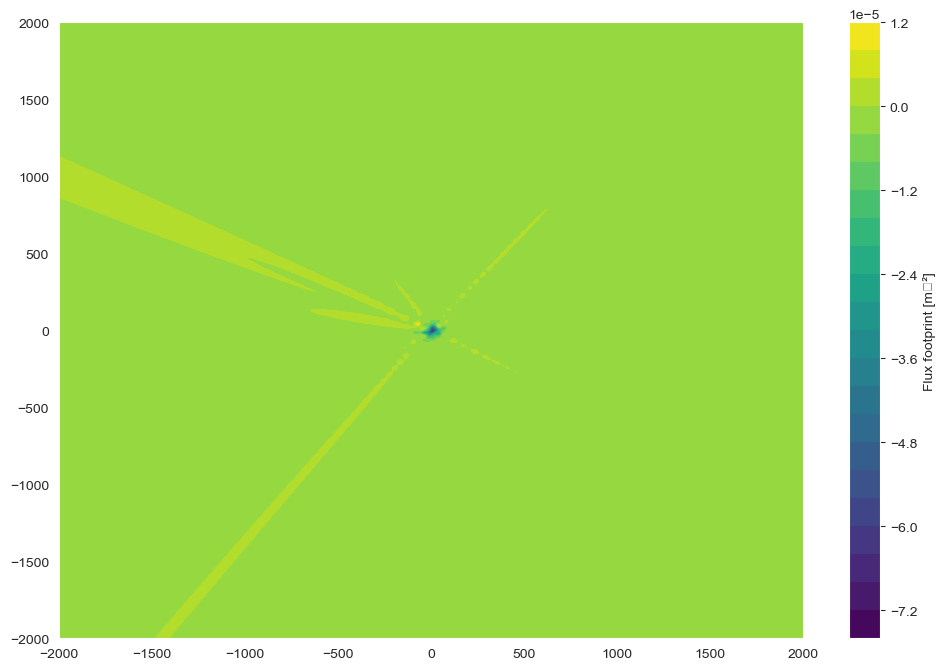

In [30]:
# Alternative: Linear scale plotting
plt.figure(figsize=(12, 8))

contourf = plt.contourf(
    results.domain_x,
    results.domain_y,
    results.footprint_climatology,
    levels=20,  # or specify explicit levels
    cmap='viridis'
)
plt.colorbar(contourf, label='Flux footprint [m⁻²]')

# Rest of plotting code remains the same...

ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x000002350A882200> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

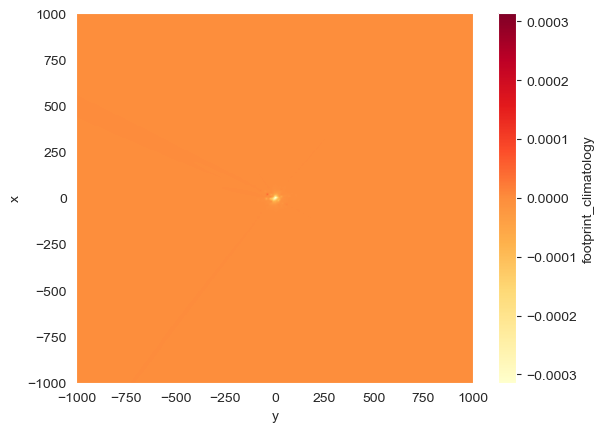

ValueError: Invalid vmin or vmax

<Figure size 1000x800 with 2 Axes>

In [27]:
# To adjust the plot limits to focus on the main footprint area:
plt.xlim(-100, 100)
plt.ylim(-50, 50)

# To change the colormap:
# Some good options for footprints: 'viridis', 'YlOrRd', 'RdBu', 'jet'
results.footprint_climatology.plot(cmap='YlOrRd')

# To plot logarithmic color scale:
import matplotlib.colors as colors
plt.figure(figsize=(10, 8))
results.footprint_climatology.plot(
    norm=colors.LogNorm(),
    cmap='viridis'
)
plt.show()

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


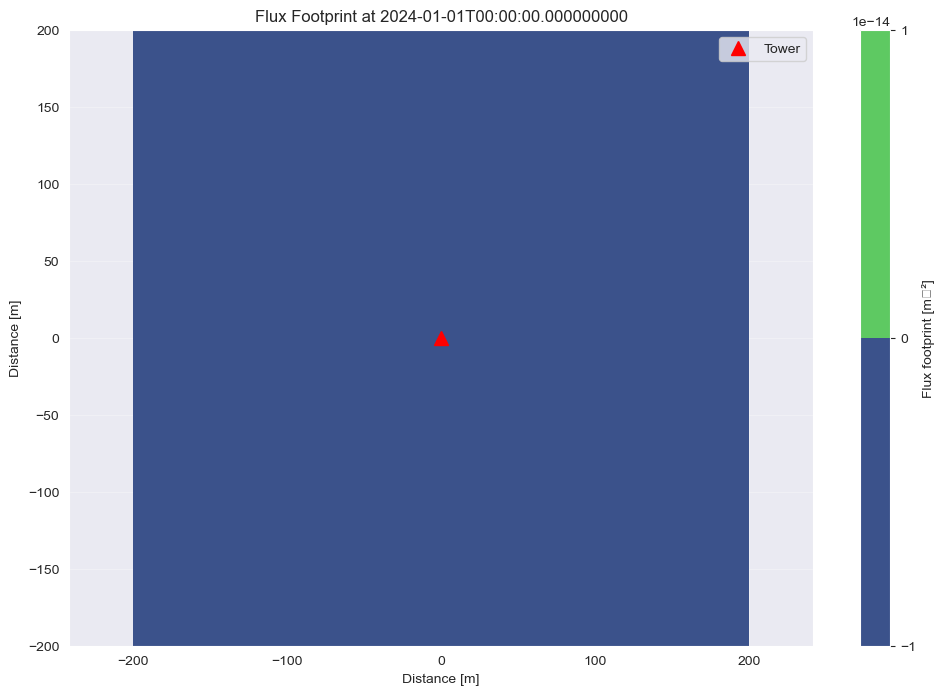

In [24]:
# Plot single timestep footprint with contours
plt.figure(figsize=(12, 8))

# Plot filled contours
timestep = 0  # Choose which timestep to plot
footprint = results.footprint_2d.isel(time=timestep)
contourf = plt.contourf(
    results.domain_x,
    results.domain_y,
    footprint,
    levels=20,
    cmap='viridis'
)
plt.colorbar(contourf, label='Flux footprint [m⁻²]')

# Add contour lines
contour = plt.contour(
    results.domain_x,
    results.domain_y,
    footprint,
    colors='white',
    levels=10,
    alpha=0.5,
    linewidths=0.5
)
plt.clabel(contour, inline=True, fontsize=8)

# Add tower location
plt.plot(0, 0, 'r^', markersize=10, label='Tower')

plt.title(f'Flux Footprint at {results.footprint_2d.time[timestep].values}')
plt.xlabel('Distance [m]')
plt.ylabel('Distance [m]')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [63]:
def get_contour_levels(f, dx, dy, rs=None):
    """
    Computes contour levels for a given array of values based on specified resolution and area fractions.

    This function is designed to determine levels for contour plotting by
    associating them with cumulative area fractions of sorted field values (`f`).

    Args:
        f (np.ndarray): The 2D array of field values for which contour levels are
            to be calculated. Array can contain NaN or infinity values, which will
            be properly handled during computation.
        dx (float): The resolution or cell size in the x-direction. Represents the
            grid spacing along the horizontal axis.
        dy (float): The resolution or cell size in the y-direction. Represents the
            grid spacing along the vertical axis.
        rs (Optional[Union[float, int, List[Union[float, int]]]]): The fractional
            areas (values between 0 and 1) for which contour levels need to be
            computed. Defaults to nine equally spaced fractions between 0.1 and
            0.9 if not provided. If `rs` is a single number, it will be converted
            into a list.

    Returns:
        List[Tuple[float, float, float]]: A list of tuples with each tuple
        containing:
            - The fractional area (rounded to three decimal places).
            - The cumulative area value at the corresponding contour level.
            - The corresponding contour level value from the input field `f`
              associated with that fractional area.

    Raises:
        ValueError: If the input `rs` is not of acceptable types (`int`, `float`,
            or `list`) or does not fall into the range between 0 and 1.
    """

    # Check input and resolve to default levels in needed
    if not isinstance(rs, (int, float, list)):
        rs = list(np.linspace(0.10, 0.90, 9))
    if isinstance(rs, (int, float)):
        rs = [rs]

    # Levels
    pclevs = np.empty(len(rs))
    pclevs[:] = np.nan
    ars = np.empty(len(rs))
    ars[:] = np.nan
    logger.debug(pclevs)

    sf = np.sort(f, axis=None)[::-1]
    msf = ma.masked_array(
        sf, mask=(np.isnan(sf) | np.isinf(sf))
    )  # Masked array for handling potential nan
    csf = msf.cumsum().filled(np.nan) * dx * dy
    for ix, r in enumerate(rs):
        dcsf = np.abs(csf - r)
        pclevs[ix] = sf[np.nanargmin(dcsf)]
        ars[ix] = csf[np.nanargmin(dcsf)]

    return pclevs, ars
    #return [(round(r, 3), ar, pclev) for r, ar, pclev in zip(rs, ars, pclevs)]

In [64]:
rs = np.arange(0.10, 1.0, 0.1)
dx = dy = 1.0
pclevs, ars = get_contour_levels(temp_ffp.fclim_2d, dx, dy, rs)
pclevs

array([0.02796121, 0.02743407, 0.02695701, 0.02665028, 0.02630905,
       0.02602179, 0.02555511, 0.02513333, 0.02488314])

In [8]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

class ContourUtils:
    @staticmethod
    def get_contour_levels(f_2d, vmin=None, vmax=None, num_levels=10):
        """
        Determine contour levels for a 2D function.

        Parameters:
        - f_2d (xarray.DataArray): 2D data array.
        - vmin (float, optional): Minimum value for contours. Defaults to data minimum.
        - vmax (float, optional): Maximum value for contours. Defaults to data maximum.
        - num_levels (int, optional): Number of contour levels. Defaults to 10.

        Returns:
        - levels (list): List of contour levels.
        """
        if vmin is None:
            vmin = f_2d.min().item()
        if vmax is None:
            vmax = f_2d.max().item()

        locator = ticker.MaxNLocator(nbins=num_levels)
        levels = locator.tick_values(vmin, vmax)

        return levels

    def get_time_varying_contour_levels(self, f_3d, vmin=None, vmax=None, num_levels=10):
        """
        Determine contour levels for a 3D xarray.DataArray over time.

        Parameters:
        - f_3d (xarray.DataArray): 3D data array with dimensions (time, x, y).
        - vmin (float, optional): Minimum value for contours. Defaults to global data minimum.
        - vmax (float, optional): Maximum value for contours. Defaults to global data maximum.
        - num_levels (int, optional): Number of contour levels. Defaults to 10.

        Returns:
        - levels_dict (dict): Dictionary with time as keys and contour levels as values.
        """
        if vmin is None:
            vmin = f_3d.min().item()
        if vmax is None:
            vmax = f_3d.max().item()

        levels_dict = {}
        for t in f_3d.time:
            f_2d = f_3d.sel(time=t)
            levels_dict[str(t.values)] = self.get_contour_levels(f_2d, vmin, vmax, num_levels)

        return levels_dict

    def plot_top_9_contour_levels(self, f_data, contour_levels, time_index=None):
        """
        Plot contours cropped to the top 9 categories for 3D xarray.DataArray.

        Parameters:
        - f_data (xarray.DataArray): 3D data array with dimensions (time, x, y).
        - contour_levels (dict): Dictionary with time as keys and contour levels as values.
        - time_index (int, optional): Index of the time slice to plot.
        """
        def plot(f_2d, levels, title):
            levels_sorted = np.sort(levels)
            cropped_levels = levels_sorted[-9:] if len(levels_sorted) >= 9 else levels_sorted

            if len(cropped_levels) == 0:
                print(f"No valid levels to plot for {title}.")
                return

            mask = (f_2d >= cropped_levels[0]) & (f_2d <= cropped_levels[-1])
            f_2d_cropped = f_2d.where(mask, drop=True)

            x_values = f_2d_cropped.x.values
            y_values = f_2d_cropped.y.values

            plt.figure(figsize=(8, 6))
            contour = plt.contourf(x_values, y_values, f_2d_cropped.values, levels=cropped_levels, cmap="viridis")
            plt.colorbar(contour, label="Value")
            plt.title(title)
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.xlim(x_values.min(), x_values.max())
            plt.ylim(y_values.min(), y_values.max())
            plt.show()

        if time_index is not None:
            f_2d = f_data.isel(time=time_index)
            time_key = str(f_data.time[time_index].values)
            plot(f_2d, contour_levels[time_key], f"Top 9 Categories Contour Plot for Time: {time_key}")
        else:
            for t in f_data.time:
                f_2d = f_data.sel(time=t)
                time_key = str(t.values)
                plot(f_2d, contour_levels[time_key], f"Top 9 Categories Contour Plot for Time: {time_key}")

    def plot_top_9_contour_levels_2d(self, f_2d, contour_levels):
        """
        Plot contours cropped to the top 9 categories for 2D xarray.DataArray.

        Parameters:
        - f_2d (xarray.DataArray): 2D data array with dimensions (x, y).
        - contour_levels (list): List of contour levels.
        """
        levels_sorted = np.sort(contour_levels)
        cropped_levels = levels_sorted[-9:] if len(levels_sorted) >= 9 else levels_sorted

        if len(cropped_levels) == 0:
            print("No valid levels to plot.")
            return

        mask = (f_2d >= cropped_levels[0]) & (f_2d <= cropped_levels[-1])
        #f_2d_cropped = f_2d.where(mask, drop=True)
        f_2d_cropped = xr.where(mask,f_2d,np.nan)


        # Ensure x and y align with data dimensions
        x_values = f_2d_cropped.x.values
        y_values = f_2d_cropped.y.values

        #if f_2d_cropped.shape != (len(y_values), len(x_values)):
        #    print("Adjusting coordinates to match data dimensions.")
        #    x_values = np.arange(f_2d_cropped.shape[1])
        #    y_values = np.arange(f_2d_cropped.shape[0])



        plt.figure(figsize=(8, 6))
        #contour = plt.contourf(x_values, y_values, f_2d_cropped.values, levels=cropped_levels, cmap="viridis")
        contour = plt.contour(x_values, y_values, f_2d_cropped.values, levels=cropped_levels, cmap="viridis")

        path = contour.get_paths()
        #polygons = []

        bbox = path[1].get_extents()


        # Access the bounding coordinates
        x_min, x_max = bbox.xmin-10, bbox.xmax+10
        y_min, y_max = bbox.ymin-10, bbox.ymax+10

        plt.colorbar(contour, label="Value")
        plt.title("Top 9 Categories Contour Plot")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.show()


# Example usage
# Assuming `f_3d` is a 3D xarray.DataArray and `contour_levels` is computed using the class above:
# utils = ContourUtils()
# contour_levels = utils.get_time_varying_contour_levels(f_3d)
# utils.plot_top_9_contour_levels(f_3d, contour_levels, time_index=0)
# For 2D data:
# f_2d = f_3d.mean(dim="time")
# levels = utils.get_contour_levels(f_2d)
# utils.plot_top_9_contour_levels_2d(f_2d, levels)


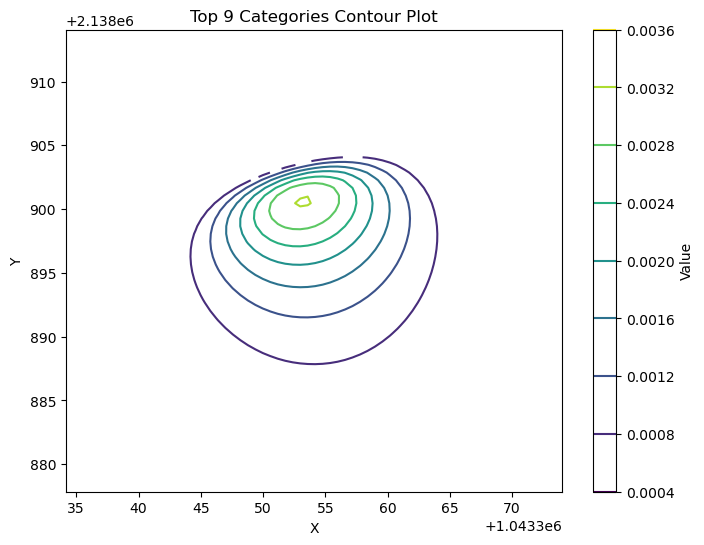

array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
       0.0032, 0.0036])

In [12]:



# Example usage
# Assuming `f_3d` is a 3D xarray.DataArray and `contour_levels` is computed using the class above:
f_3d = ds_albers.sel(time=pd.to_datetime("2011-01-01 20:00"),method="nearest")
utils = ContourUtils()
contour_levels = utils.get_contour_levels(f_3d)
utils.plot_top_9_contour_levels_2d(f_3d, contour_levels)
contour_levels

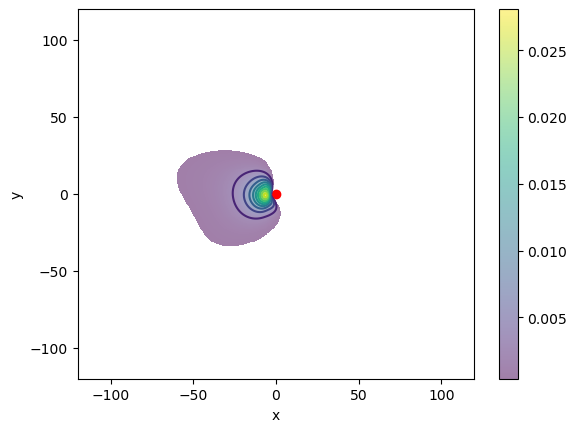

In [45]:
#ds_albers_filt = ds_albers.sel(time=pd.to_datetime("2011-01-01 20:00"),method="nearest")#xr.where(ds_albers_day>0.0002,ds_albers_day,np.nan)
ds_albers_filt = temp_ffp.fclim_2d
ds_albers_filt = xr.where(ds_albers_filt>0.0004,ds_albers_filt,np.nan)
utils = ContourUtils()
contour_levels = utils.get_contour_levels(ds_albers_filt, num_levels=10)
ds_albers_filt.plot(x="x",y="y",xlim=[-120,120],ylim=[-120,120],alpha=0.5)
cntr = ds_albers_filt.plot.contour(x="x",y="y",#xlim=[1043200,1043375],ylim=[2138800,2139000],
                                       levels=contour_levels)
plt.scatter(0,0, color="red")

In [53]:
import numpy as np
import xarray as xr

# Example 2D array
data = np.random.rand(10, 10)
f = xr.DataArray(data, dims=["y", "x"], coords={"y": np.arange(10), "x": np.arange(10)})

# Define grid resolution
dx, dy = 1.0, 1.0

# Compute contour levels
contour_levels = get_contour_levels(ds_albers_day, dx, dy, rs=[0.2, 0.5, 0.8])

# Print results
for fractional_area, cumulative_area, level in contour_levels:
    print(f"Fractional Area: {fractional_area}, Cumulative Area: {cumulative_area}, Level: {level}")


Fractional Area: 0.2, Cumulative Area: 0.19468175833910173, Level: 0.027434071328849553
Fractional Area: 0.5, Cumulative Area: 0.4896355720610551, Level: 0.02630904780712536
Fractional Area: 0.8, Cumulative Area: 0.798129863511776, Level: 0.02513332862930748


In [54]:
level

np.float64(0.02513332862930748)

Levels: [0.00422654 0.00420011 0.0041048  0.00407862 0.00405693 0.0040043
 0.00388146 0.00387698 0.00382011]
Areas: [0.11446814 0.1901744  0.30175744 0.41209935 0.48526949 0.59387066
 0.70041514 0.80511636 0.90854699]


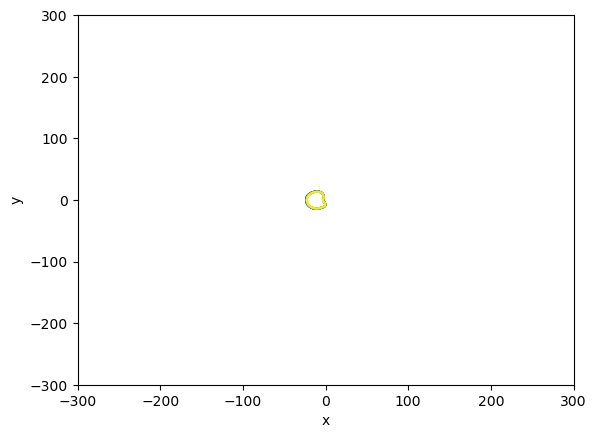

In [70]:


# Create a sample xarray.DataArray
data = np.random.rand(10, 10)

# Reference values and spatial resolution
rs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])  # Example cumulative thresholds
dx, dy = 3.0, 3.0  # Example spatial resolution

# Call the function
pclevs, ars = get_contour_levels(temp_ffp.f_2d, dx, dy,rs)

# Output results
print("Levels:", pclevs)
print("Areas:", ars)

ds_albers_filt.plot.contour(x="x",y="y",levels=pclevs)

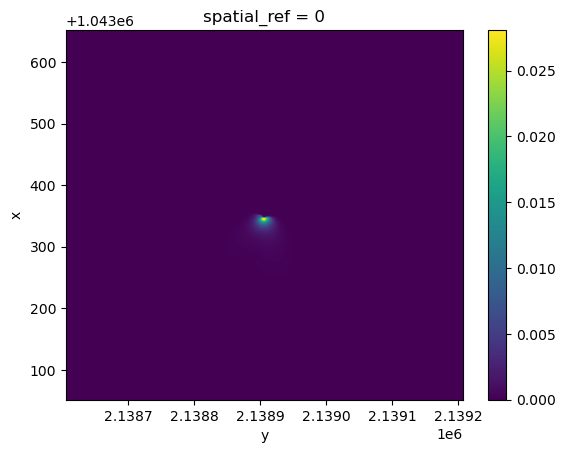

In [69]:
ds_albers_day.plot()

<xarray.DataArray (x: 1001, y: 1001)> Size: 8MB
array([[1.11412864e-06, 1.12772712e-06, 1.14139069e-06, ...,
        3.44629024e-11, 3.26107733e-11, 3.08587303e-11],
       [1.10711151e-06, 1.12073146e-06, 1.13441879e-06, ...,
        3.34953570e-11, 3.16952391e-11, 2.99923956e-11],
       [1.10003649e-06, 1.11367596e-06, 1.12738511e-06, ...,
        3.25548314e-11, 3.08052663e-11, 2.91502423e-11],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * x            (x) float64 8kB 1.043e+06 1.043e+06 ... 1.044e+06 1.044e+06
  * y            (y) float64 8kB 2.139e+06 2.139e+06 ... 2.139e+06 2.139e+06
    spatial_ref  int64 8B 0

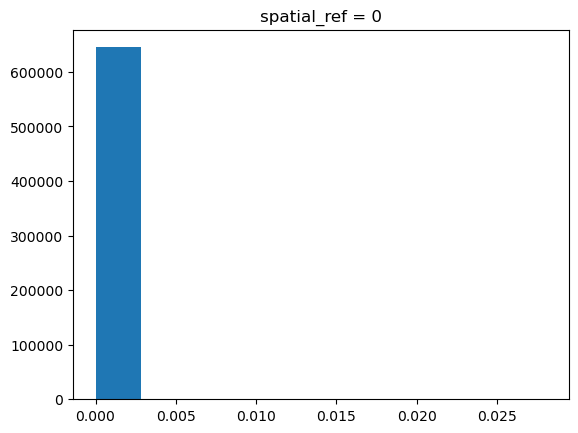

In [24]:
data = xr.where(ds_albers_day>0.0,ds_albers_day,np.nan)
# Plot 2D histogram
#plt.hist2d(data.values.ravel(), data.values.ravel(), bins=20)
#plt.colorbar()
#plt.show()
data.plot.hist()
data

In [21]:
import matplotlib.path as mpath
import geopandas as gpd
import shapely.geometry as sgeom

path = cntr.get_paths()
polygons = []
maxvals = []
minvals = []

bbox = path[-2].get_extents()


# Access the bounding coordinates
x_min, x_max = bbox.xmin, bbox.xmax
y_min, y_max = bbox.ymin, bbox.ymax

for p in path:
    # Convert the path to a Shapely polygon
    maxvals.append(np.max(p[0]))
    minvals.append(np.min(p[0]))
    #polygons.append(sgeom.Polygon(p.vertices))
print(np.max(maxvals))
print(np.min(minvals))

# Create a GeoDataFrame from the polygon
#gdf = gpd.GeoDataFrame([0.,10,20,30,40,50,60,70,80,90,100],geometry=polygons)

In [37]:
bbox = path[-2].get_extents()


# Access the bounding coordinates
x_min, x_max = bbox.xmin, bbox.xmax
y_min, y_max = bbox.ymin, bbox.ymax

In [87]:
len(path)

11

In [75]:
vmax = ds_albers_day_filt.max().item()
vmax

0.028076515669917815

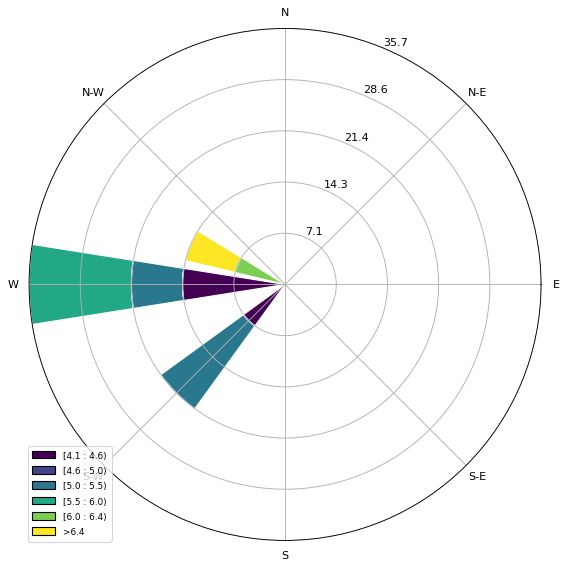

In [13]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(temp_line['wd'], temp_line['ws'], normed=True, opening=0.8, edgecolor="white")
ax.set_legend()

In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union


def calculate_percentile_polygons(xarray_layer, percentiles):
    """
    Calculate polygons representing given percentiles of f values in a 2D xarray layer.

    Parameters:
        xarray_layer (xr.DataArray): 2D array of f values with coordinate information.
        percentiles (list): List of percentiles (e.g., [90, 80, ..., 10]).

    Returns:
        dict: A dictionary where keys are percentiles and values are lists of polygons.
    """
    from shapely.geometry import Polygon
    from shapely.ops import unary_union

    polygons = {}

    # Flatten the data to calculate percentiles
    f_values = xarray_layer.values.flatten()
    percentile_values = np.percentile(f_values, percentiles)

    for pct, cutoff in zip(percentiles, percentile_values):
        # Create a mask for values above the cutoff
        mask = xarray_layer >= cutoff

        # Extract contours
        fig, ax = plt.subplots()
        contour = ax.contour(mask, levels=[0.5])  # Binary mask, so level is 0.5
        plt.close(fig)  # Close the plot to avoid displaying it

        # Convert contours to polygons
        pct_polygons = []
        for path in contour.get_paths():  # Updated to use get_paths directly
            # Get vertices and create a polygon
            vertices = path.vertices
            if len(vertices) > 2:  # Valid polygon
                polygon = Polygon(vertices)
                pct_polygons.append(polygon)

        # Store the merged polygons for this percentile
        polygons[pct] = unary_union(pct_polygons)

    return polygons


import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

def plot_polygons(polygons_dict, xarray_layer, figsize=(10, 8)):
    """
    Plot polygons representing percentiles on top of the original xarray layer.

    Parameters:
        polygons_dict (dict): Dictionary where keys are percentiles and values are polygons (Shapely).
        xarray_layer (xr.DataArray): Original 2D xarray layer for reference.
        figsize (tuple): Size of the plot.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the xarray layer as the background
    im = ax.imshow(xarray_layer, origin='lower', cmap='viridis', extent=[
        xarray_layer.coords[xarray_layer.dims[1]].min(),
        xarray_layer.coords[xarray_layer.dims[1]].max(),
        xarray_layer.coords[xarray_layer.dims[0]].min(),
        xarray_layer.coords[xarray_layer.dims[0]].max()
    ])
    plt.colorbar(im, ax=ax, label="f values")

    # Overlay the polygons
    for pct, geometry in polygons_dict.items():
        if isinstance(geometry, Polygon):
            # Single polygon
            x, y = geometry.exterior.xy
            ax.plot(x, y, label=f"{pct}%", alpha=0.7)
        elif isinstance(geometry, MultiPolygon):
            # Multiple polygons
            for poly in geometry.geoms:
                x, y = poly.exterior.xy
                ax.plot(x, y, label=f"{pct}%", alpha=0.7)
        elif isinstance(geometry, GeometryCollection):
            # Handle GeometryCollection
            for geom in geometry.geoms:
                if isinstance(geom, Polygon):
                    x, y = geom.exterior.xy
                    ax.plot(x, y, label=f"{pct}%", alpha=0.7)
                elif isinstance(geom, MultiPolygon):
                    for poly in geom.geoms:
                        x, y = poly.exterior.xy
                        ax.plot(x, y, label=f"{pct}%", alpha=0.7)

    # Configure the plot
    ax.legend(loc='upper right')
    ax.set_title("Polygons Representing Percentiles")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    plt.show()





In [24]:
# Example usage
# Assume xarray_layer is a 2D xr.DataArray with coordinates
percentiles = [90, 80, 70, 60, 50, 40, 30, 20, 10]
polygons = calculate_percentile_polygons(ds_albers_day, percentiles)
print(polygons)
#polygons[60].plot()

{90: <POLYGON ((569 66.5, 570 66.5, 571 66.5, 572 66.5, 573 66.5, 574 66.5, 575 6...>, 80: <POLYGON ((725.5 0, 725.5 1, 725.5 2, 725.5 3, 725.5 4, 725.5 5, 725 5.5, 72...>, 70: <POLYGON ((828.5 0, 828 0.5, 827.5 1, 827.5 2, 827 2.5, 826.5 3, 826.5 4, 82...>, 60: <POLYGON ((984.5 0, 984 0.5, 983.5 1, 983.5 2, 983 2.5, 982.5 3, 982 3.5, 98...>, 50: <POLYGON ((1000 321.5, 999.5 322, 999 322.5, 998.5 323, 998 323.5, 997.5 324...>, 40: <POLYGON ((1000 540.5, 999.5 541, 999 541.5, 998 541.5, 997 541.5, 996 541.5...>, 30: <GEOMETRYCOLLECTION EMPTY>, 20: <GEOMETRYCOLLECTION EMPTY>, 10: <GEOMETRYCOLLECTION EMPTY>}


In [29]:
temp_ffp.fclim_2d

<xarray.DataArray (x: 1001, y: 1001)> Size: 8MB
array([[1.11412864e-06, 1.12772712e-06, 1.14139069e-06, ...,
        3.44629024e-11, 3.26107733e-11, 3.08587303e-11],
       [1.10711151e-06, 1.12073146e-06, 1.13441879e-06, ...,
        3.34953570e-11, 3.16952391e-11, 2.99923956e-11],
       [1.10003649e-06, 1.11367596e-06, 1.12738511e-06, ...,
        3.25548314e-11, 3.08052663e-11, 2.91502423e-11],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * x        (x) float64 8kB -300.0 -299.4 -298.8 -298.2 ... 298.8 299.4 300.0
  * y        (y) float64 8kB -300.0 -299.4 -298.8 -298.2 ... 298.8 299.4 300.0

In [31]:
import numpy as np
import xarray as xr
from numpy import ma

def get_contour_levels_xr(f: xr.DataArray, dx: float, dy: float, rs=None):
    """
    Computes contour levels for a given xarray DataArray based on specified resolution and area fractions.

    This function determines levels for contour plotting by associating them with cumulative
    area fractions of sorted field values (`f`).

    Args:
        f (xr.DataArray): The 2D xarray DataArray of field values for which contour levels are
            to be calculated. The array can contain NaN or infinity values, which will
            be properly handled during computation.
        dx (float): The resolution or cell size in the x-direction.
        dy (float): The resolution or cell size in the y-direction.
        rs (Optional[Union[float, int, List[Union[float, int]]]]): The fractional
            areas (values between 0 and 1) for which contour levels need to be computed.
            Defaults to nine equally spaced fractions between 0.1 and 0.9 if not provided.
            If `rs` is a single number, it will be converted into a list.

    Returns:
        List[Tuple[float, float, float]]: A list of tuples with each tuple containing:
            - The fractional area (rounded to three decimal places).
            - The cumulative area value at the corresponding contour level.
            - The corresponding contour level value from the input field `f`.
    """
    # Resolve default area fractions
    if not isinstance(rs, (int, float, list)):
        rs = list(np.linspace(0.10, 0.90, 9))
    if isinstance(rs, (int, float)):
        rs = [rs]

    # Flatten the DataArray while preserving NaN and Inf handling
    sf = np.sort(f.values.ravel()[~np.isnan(f.values.ravel())][::-1])
    msf = ma.masked_array(sf, mask=(np.isnan(sf) | np.isinf(sf)))

    # Compute cumulative sums for area calculation
    csf = msf.cumsum().filled(np.nan) * dx * dy

    # Find levels corresponding to requested fractions
    pclevs = np.empty(len(rs))
    pclevs[:] = np.nan
    ars = np.empty(len(rs))
    ars[:] = np.nan

    for ix, r in enumerate(rs):
        dcsf = np.abs(csf - r)
        pclevs[ix] = sf[np.nanargmin(dcsf)]
        ars[ix] = csf[np.nanargmin(dcsf)]

    return ars #[(round(r, 3), ar, pclev) for r, ar, pclev in zip(rs, ars, pclevs)]

def get_contour_levels(f, dx, dy, rs=None):
    """
    Computes contour levels for a given array of values based on specified resolution and area fractions.

    This function is designed to determine levels for contour plotting by
    associating them with cumulative area fractions of sorted field values (`f`).

    Args:
        f (np.ndarray): The 2D array of field values for which contour levels are
            to be calculated. Array can contain NaN or infinity values, which will
            be properly handled during computation.
        dx (float): The resolution or cell size in the x-direction. Represents the
            grid spacing along the horizontal axis.
        dy (float): The resolution or cell size in the y-direction. Represents the
            grid spacing along the vertical axis.
        rs (Optional[Union[float, int, List[Union[float, int]]]]): The fractional
            areas (values between 0 and 1) for which contour levels need to be
            computed. Defaults to nine equally spaced fractions between 0.1 and
            0.9 if not provided. If `rs` is a single number, it will be converted
            into a list.

    Returns:
        List[Tuple[float, float, float]]: A list of tuples with each tuple
        containing:
            - The fractional area (rounded to three decimal places).
            - The cumulative area value at the corresponding contour level.
            - The corresponding contour level value from the input field `f`
              associated with that fractional area.

    Raises:
        ValueError: If the input `rs` is not of acceptable types (`int`, `float`,
            or `list`) or does not fall into the range between 0 and 1.
    """

    # Check input and resolve to default levels in needed
    if not isinstance(rs, (int, float, list)):
        rs = list(np.linspace(0.10, 0.90, 9))
    if isinstance(rs, (int, float)):
        rs = [rs]

    # Levels
    pclevs = np.empty(len(rs))
    pclevs[:] = np.nan
    ars = np.empty(len(rs))
    ars[:] = np.nan
    logger.debug(pclevs)

    sf = np.sort(f, axis=None)[::-1]
    msf = ma.masked_array(
        sf, mask=(np.isnan(sf) | np.isinf(sf))
    )  # Masked array for handling potential nan
    csf = msf.cumsum().filled(np.nan) * dx * dy
    for ix, r in enumerate(rs):
        dcsf = np.abs(csf - r)
        pclevs[ix] = sf[np.nanargmin(dcsf)]
        ars[ix] = csf[np.nanargmin(dcsf)]

    return [(round(r, 3), ar, pclev) for r, ar, pclev in zip(rs, ars, pclevs)]

def get_contour_vertices(x, y, f, lev):
    # import matplotlib._contour as cntr
    import matplotlib.pyplot as plt

    cs = plt.contour(x, y, f, [lev])
    plt.close()
    segs = cs.allsegs[0][0]
    logger.debug(segs)
    xr = [vert[0] for vert in segs]
    yr = [vert[1] for vert in segs]
    # Set contour to None if it's found to reach the physical domain
    if (
        x.min() >= min(segs[:, 0])
        or max(segs[:, 0]) >= x.max()
        or y.min() >= min(segs[:, 1])
        or max(segs[:, 1]) >= y.max()
    ):
        return [None, None]

    return [xr, yr]  # x,y coords of contour points.

In [46]:
lev = get_contour_levels_xr(temp_ffp.fclim_2d,10,10)
#verts = get_contour_vertices(temp_ffp.fclim_2d.x,temp_ffp.fclim_2d.y,temp_ffp.fclim_2d.values,lev)

In [47]:
lev

array([0.09999708, 0.19999639, 0.30000281, 0.39999493, 0.4999883 ,
       0.59999793, 0.70001795, 0.7999922 , 0.89998582])

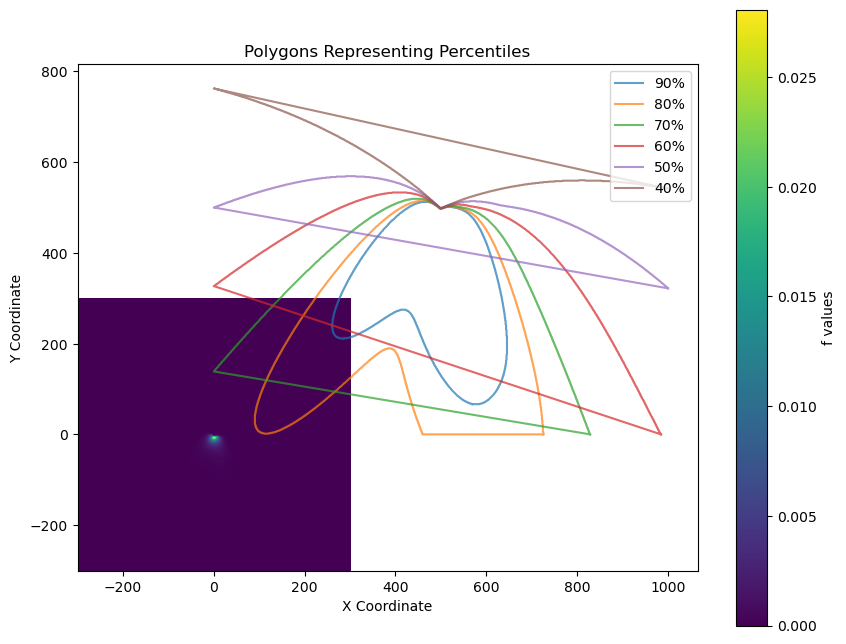

In [28]:
# Assuming xarray_layer is your 2D raster and polygons is the output dictionary
polygons = calculate_percentile_polygons(temp_ffp.fclim_2d, [90, 80, 70, 60, 50, 40, 30, 20, 10])

# Plot the results
plot_polygons(polygons, temp_ffp.fclim_2d)

#ds_albers_day = temp_ffp.fclim_2d.assign_coords(x=x_2d, y=y_2d).rio.write_crs(5070)

# View footprint raster

First plot shows georeferenced (UTM zone 17) footprint (first bad at 7:00 AM) and the plot below shows a different hour, the third plot shows the daily average using matplotlib. Not the second two plots are not georefenced and the axes are in pixel count.

In [20]:
plt.figure(figsize=(14,14))
src = rasterio.open("2024-07-22_US-UTP.tif")
show(src)

RasterioIOError: '2024-07-22_US-UTP.tif' not recognized as being in a supported file format.

<Figure size 1400x1400 with 0 Axes>

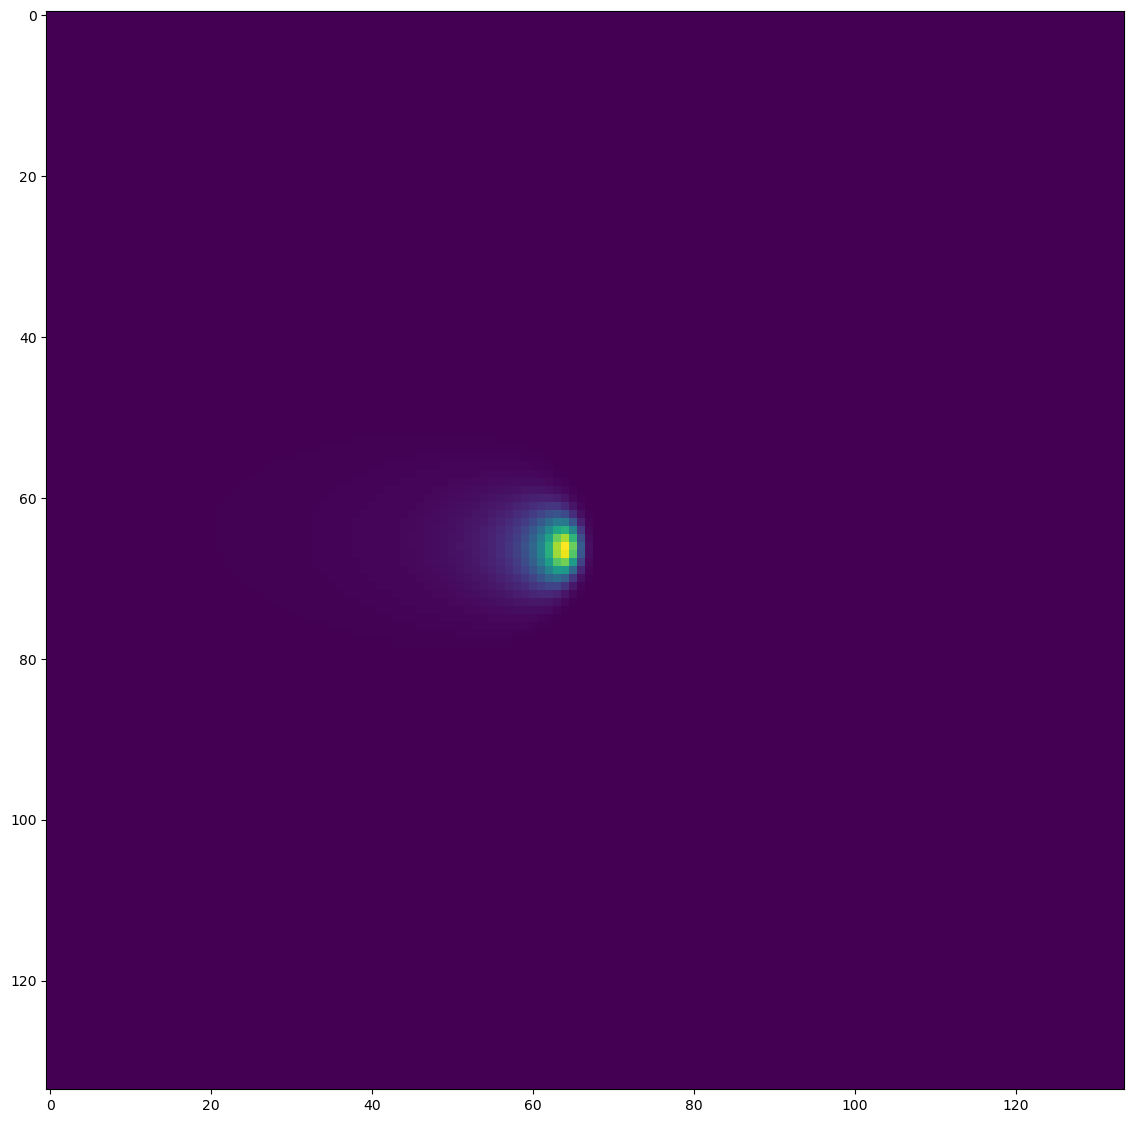

<Axes: >

In [11]:
# view a band for the hour of 10:00 AM (4th band)
plt.figure(figsize=(14,14))
src = rasterio.open("../../footprints/data/2011-01-01_US-CRT.tif")
show(src.read(4))